In [150]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [151]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22015 entries, 0 to 22014
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22015 non-null  object 
 1   description               22015 non-null  object 
 2   summary                   22014 non-null  object 
 3   installs                  22015 non-null  object 
 4   minInstalls               22015 non-null  float64
 5   score                     22015 non-null  float64
 6   ratings                   22015 non-null  float64
 7   reviews                   22015 non-null  float64
 8   histogram                 22015 non-null  object 
 9   price                     22015 non-null  float64
 10  free                      22015 non-null  int64  
 11  currency                  22015 non-null  object 
 12  sale                      22015 non-null  bool   
 13  offersIAP                 22015 non-null  bool   
 14  inAppP

In [152]:
df_sentiment = pd.read_csv('merged_sentiment.csv')

In [153]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='title',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [154]:
df = df[df['updated_year'] > 2013]

In [155]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

y = df['score']

In [156]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

In [157]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

In [158]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_tr[['genre','contentRating']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [159]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [160]:
# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

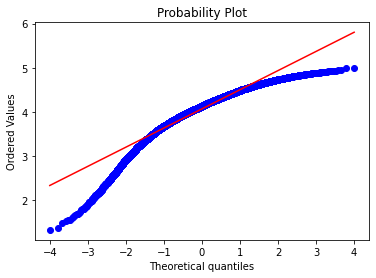

In [161]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 21888
- Mean of distribution of rating : 4.068367483223653
- Standard deviation: 0.4495861122060895


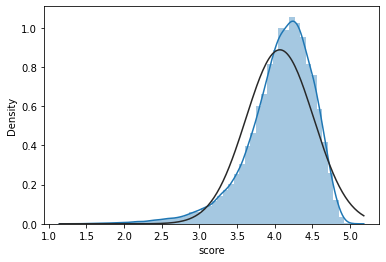

In [162]:
sns.distplot(df['score'],fit=stats.norm)
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))

## No pipeline

In [163]:
features = ['ratings', 'free', 'containsAds', 'editorsChoice', 'year',
       'top_developer', 'installs_day', 'updated_days', 'has_video',
       'compound', 'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Events', 'genre_Finance', 'genre_Food & Drink',
       'genre_Health & Fitness', 'genre_House & Home',
       'genre_Libraries & Demo', 'genre_Lifestyle', 'genre_Maps & Navigation',
       'genre_Medical', 'genre_Music', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'genre_Simulation', 'genre_Social', 'genre_Sports', 'genre_Strategy',
       'genre_Tools', 'genre_Travel & Local', 'genre_Trivia',
       'genre_Video Players & Editors', 'genre_Weather', 'genre_Word',
       'contentRating_Everyone 10+', 'contentRating_Mature 17+',
       'contentRating_Teen']

In [164]:
lr = LinearRegression()

lr.fit(X_train[features], y_train)

y_pred = lr.predict(X_val[features])
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val[features], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.41
MSE of linear regression on val set: 0.11
MAE of linear regression on val set: 0.25


In [165]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features].columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.06
containsAds : 0.01
editorsChoice : 0.08
year : -0.01
top_developer : 0.37
installs_day : 0.00
updated_days : -0.00
has_video : 0.04
compound : 1.16
genre_Adventure : -0.12
genre_Arcade : 0.00
genre_Art & Design : -0.08
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.17
genre_Board : 0.07
genre_Books & Reference : 0.12
genre_Business : 0.10
genre_Card : 0.16
genre_Casino : 0.18
genre_Casual : -0.04
genre_Comics : -0.13
genre_Communication : 0.06
genre_Dating : -0.01
genre_Education : 0.01
genre_Entertainment : -0.04
genre_Events : -0.28
genre_Finance : 0.08
genre_Food & Drink : 0.11
genre_Health & Fitness : 0.12
genre_House & Home : 0.12
genre_Libraries & Demo : -0.07
genre_Lifestyle : -0.01
genre_Maps & Navigation : 0.13
genre_Medical : 0.05
genre_Music : -0.11
genre_Music & Audio : 0.06
genre_News & Magazines : -0.04
genre_Parenting : 0.06
genre_Personalization : 0.09
genre_Photography : -0.07
genre_Productivity : 0.06
genre_Puz

In [166]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(X_val[features])
check['resid'] = check['pred'] - check['score']

In [167]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [168]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7955,763222.0,0,0,0,2013,1,362.187613,1204,1,0.297678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.615131,7.005799,2.390668
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.815431,1.963966
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.584928,1.958452
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.810729,1.937306
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.821727,1.806538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13266,50414.0,1,1,0,2016,0,533.049041,19,0,0.081689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.581501,3.811120,-0.770381
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.751869,-0.776432
889,5725.0,1,1,0,2016,0,637.755102,1506,0,-0.140245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.137631,3.354823,-0.782807
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.699261,-0.837504


In [169]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

In [170]:
high_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,20874.023333,0.993333,0.813333,0.003333,2016.283333,0.031667,979.951223,363.385000,0.265000,0.236834,...,0.005000,0.020000,0.008333,0.001667,0.038333,0.050000,0.163333,3.471419,4.020029,0.548610
std,51914.672801,0.081445,0.389969,0.057687,2.437134,0.175257,954.393428,431.582011,0.441701,0.245523,...,0.070593,0.140117,0.090982,0.040825,0.192160,0.218127,0.369978,0.492850,0.381758,0.294561
min,1000.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,247.647350,0.000000,0.000000,-0.296802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.589474,3.215328,0.262554
25%,3724.000000,1.000000,1.000000,0.000000,2015.000000,0.000000,465.928965,41.000000,0.000000,0.051489,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.212945,3.770849,0.344720
50%,7001.500000,1.000000,1.000000,0.000000,2017.000000,0.000000,670.246104,188.000000,0.000000,0.191675,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.490698,3.943562,0.461827
75%,15742.000000,1.000000,1.000000,0.000000,2018.000000,0.000000,1139.602251,556.250000,1.000000,0.390571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.765762,4.212329,0.649048
max,763222.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,8196.721311,2442.000000,1.000000,0.897580,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.885803,7.005799,2.390668


In [171]:
low_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000,...,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000,931.000000
mean,22758.646617,0.996778,0.857143,0.009667,2016.210526,0.089151,987.830709,349.302900,0.372718,0.284733,...,0.005371,0.011815,0.010741,0.007519,0.056928,0.045113,0.157895,4.116174,4.114796,-0.001379
std,29434.747517,0.056705,0.350115,0.097897,2.540582,0.285115,950.367249,479.551056,0.483788,0.175765,...,0.073126,0.108112,0.103137,0.086431,0.231830,0.207663,0.364838,0.303554,0.297683,0.058523
min,1023.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,249.875062,0.000000,0.000000,-0.318454,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.363347,3.346489,-0.099713
25%,5611.500000,1.000000,1.000000,0.000000,2014.000000,0.000000,437.349849,30.000000,0.000000,0.179284,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.910408,3.916691,-0.052395
50%,11621.000000,1.000000,1.000000,0.000000,2017.000000,0.000000,682.593857,149.000000,0.000000,0.299384,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.094931,4.093635,-0.002767
75%,26289.500000,1.000000,1.000000,0.000000,2018.000000,0.000000,1126.769504,457.500000,1.000000,0.394518,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.310465,4.295121,0.047570
max,244762.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,8695.652174,2564.000000,1.000000,0.886290,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.883638,4.919978,0.099611


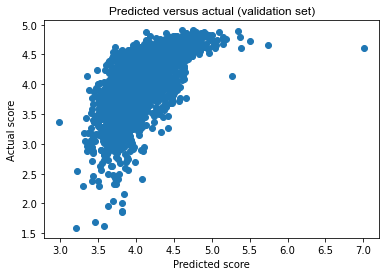

In [172]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

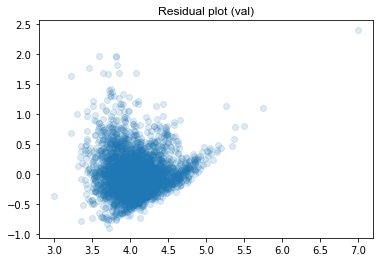

In [173]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

## Removing ratings

The sections below iteratively remove features which the model is not using (0.0) or which have very low coefficients. This is to manage for overfitting

In [174]:
features2 = features.copy()
features2.remove('ratings')

In [175]:
lr2 = LinearRegression()

lr2.fit(X_train[features2], y_train)

y_pred2 = lr2.predict(X_val[features2])
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(X_val[features2], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred2))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred2))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [176]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features2].columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.17
year : -0.01
top_developer : 0.46
installs_day : 0.00
updated_days : -0.00
has_video : 0.07
compound : 1.15
genre_Adventure : -0.11
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.18
genre_Board : 0.06
genre_Books & Reference : 0.11
genre_Business : 0.08
genre_Card : 0.18
genre_Casino : 0.24
genre_Casual : -0.04
genre_Comics : -0.17
genre_Communication : 0.05
genre_Dating : -0.03
genre_Education : -0.02
genre_Entertainment : -0.06
genre_Events : -0.33
genre_Finance : 0.11
genre_Food & Drink : 0.10
genre_Health & Fitness : 0.10
genre_House & Home : 0.10
genre_Libraries & Demo : -0.04
genre_Lifestyle : -0.02
genre_Maps & Navigation : 0.12
genre_Medical : 0.04
genre_Music : -0.07
genre_Music & Audio : 0.04
genre_News & Magazines : -0.05
genre_Parenting : 0.03
genre_Personalization : 0.07
genre_Photography : -0.09
genre_Productivity : 0.04
genre_Puzzle : 0.12
g

In [177]:
check2 = X_val.copy()
check2['score'] = y_val
check2['pred'] = lr2.predict(X_val[features2])
check2['resid'] = check2['pred'] - check2['score']

In [178]:
check2.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.882474,2.031010
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.580440,1.953964
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.812852,1.939429
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.907858,1.892670
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.471376,1.774550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9174,35283.0,1,0,0,2019,0,1517.450683,527,0,-0.100061,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.393734,3.609839,-0.783895
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.718329,-0.818435
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.694001,-0.820363
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.766153,-0.864429


## Removing installs / day

In [179]:
features3 = features2.copy()
features3.remove('installs_day')

In [180]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred3))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred3))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [181]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
year : -0.01
top_developer : 0.46
updated_days : -0.00
has_video : 0.07
compound : 1.15
genre_Adventure : -0.11
genre_Arcade : 0.02
genre_Art & Design : -0.10
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.18
genre_Board : 0.06
genre_Books & Reference : 0.12
genre_Business : 0.08
genre_Card : 0.18
genre_Casino : 0.23
genre_Casual : -0.04
genre_Comics : -0.17
genre_Communication : 0.05
genre_Dating : -0.03
genre_Education : -0.02
genre_Entertainment : -0.06
genre_Events : -0.32
genre_Finance : 0.11
genre_Food & Drink : 0.10
genre_Health & Fitness : 0.10
genre_House & Home : 0.11
genre_Libraries & Demo : -0.04
genre_Lifestyle : -0.02
genre_Maps & Navigation : 0.12
genre_Medical : 0.05
genre_Music : -0.07
genre_Music & Audio : 0.04
genre_News & Magazines : -0.05
genre_Parenting : 0.03
genre_Personalization : 0.07
genre_Photography : -0.09
genre_Productivity : 0.04
genre_Puzzle : 0.12
genre_Racing : -0.03


In [182]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [183]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.888434,2.036969
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.811428,1.938005
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.561290,1.934814
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.888930,1.873742
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.477653,1.780827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.738307,-0.789994
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.730396,-0.806369
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.706233,-0.808131
13266,50414.0,1,1,0,2016,0,533.049041,19,0,0.081689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.581501,3.715696,-0.865805


## Removing updated days

In [184]:
features4 = features3.copy()
features4.remove('updated_days')

In [185]:
lr4 = LinearRegression()

lr4.fit(X_train[features4], y_train)

y_pred4 = lr4.predict(X_val[features4])
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(X_val[features4], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(mean_squared_error(y_val, y_pred4)))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred4))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [186]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features4].columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
year : -0.00
top_developer : 0.46
has_video : 0.07
compound : 1.16
genre_Adventure : -0.10
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.11
genre_Beauty : -0.17
genre_Board : 0.08
genre_Books & Reference : 0.14
genre_Business : 0.10
genre_Card : 0.19
genre_Casino : 0.25
genre_Casual : -0.03
genre_Comics : -0.15
genre_Communication : 0.06
genre_Dating : -0.00
genre_Education : -0.01
genre_Entertainment : -0.05
genre_Events : -0.30
genre_Finance : 0.14
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.12
genre_House & Home : 0.13
genre_Libraries & Demo : -0.04
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.15
genre_Medical : 0.08
genre_Music : -0.07
genre_Music & Audio : 0.05
genre_News & Magazines : -0.02
genre_Parenting : 0.06
genre_Personalization : 0.07
genre_Photography : -0.08
genre_Productivity : 0.06
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : 

In [187]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [188]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.888434,2.036969
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.811428,1.938005
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.561290,1.934814
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.888930,1.873742
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.477653,1.780827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.738307,-0.789994
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.730396,-0.806369
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.706233,-0.808131
13266,50414.0,1,1,0,2016,0,533.049041,19,0,0.081689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.581501,3.715696,-0.865805


## Removing year and mature

In [189]:
features5 = features4.copy()
features5.remove('year')
features5.remove('contentRating_Mature 17+')

In [190]:
lr5 = LinearRegression()

lr5.fit(X_train[features5], y_train)

y_pred5 = lr5.predict(X_val[features5])
print('R^2 of linear regression on val set: {:.2f}'.format(lr5.score(X_val[features5], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred5))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred5))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [191]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features5].columns, lr5.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.15
genre_Adventure : -0.10
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.17
genre_Board : 0.08
genre_Books & Reference : 0.15
genre_Business : 0.11
genre_Card : 0.20
genre_Casino : 0.26
genre_Casual : -0.03
genre_Comics : -0.15
genre_Communication : 0.07
genre_Dating : -0.01
genre_Education : 0.00
genre_Entertainment : -0.04
genre_Events : -0.31
genre_Finance : 0.15
genre_Food & Drink : 0.13
genre_Health & Fitness : 0.12
genre_House & Home : 0.14
genre_Libraries & Demo : -0.03
genre_Lifestyle : 0.00
genre_Maps & Navigation : 0.16
genre_Medical : 0.09
genre_Music : -0.06
genre_Music & Audio : 0.06
genre_News & Magazines : -0.01
genre_Parenting : 0.07
genre_Personalization : 0.08
genre_Photography : -0.07
genre_Productivity : 0.07
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Sho

In [192]:
check5 = X_val.copy()
check5['score'] = y_val
check5['pred'] = lr5.predict(X_val[features5])
check5['resid'] = check5['pred'] - check5['score']

In [193]:
check5.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.872221,2.020756
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.623360,1.996884
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.771288,1.897865
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.845105,1.829917
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.497873,1.801048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.749314,-0.778988
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.713745,-0.800619
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.731718,-0.805046
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.746695,-0.883887


## Removing weather and dating

In [194]:
features6 = features5.copy()
features6.remove('genre_Weather')
features6.remove('genre_Dating')

In [195]:
lr6 = LinearRegression()

lr6.fit(X_train[features6], y_train)

y_pred6 = lr6.predict(X_val[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(X_val[features6], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred6))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred6))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [196]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features6].columns, lr6.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.15
genre_Adventure : -0.11
genre_Arcade : 0.02
genre_Art & Design : -0.10
genre_Auto & Vehicles : 0.11
genre_Beauty : -0.18
genre_Board : 0.08
genre_Books & Reference : 0.14
genre_Business : 0.11
genre_Card : 0.20
genre_Casino : 0.25
genre_Casual : -0.03
genre_Comics : -0.16
genre_Communication : 0.06
genre_Education : -0.00
genre_Entertainment : -0.05
genre_Events : -0.31
genre_Finance : 0.15
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.12
genre_House & Home : 0.14
genre_Libraries & Demo : -0.04
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.15
genre_Medical : 0.09
genre_Music : -0.07
genre_Music & Audio : 0.06
genre_News & Magazines : -0.01
genre_Parenting : 0.06
genre_Personalization : 0.07
genre_Photography : -0.08
genre_Productivity : 0.06
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Shopping : 0.17
genre_

In [197]:
check6 = X_val.copy()
check6['score'] = y_val
check6['pred'] = lr6.predict(X_val[features6])
check6['resid'] = check6['pred'] - check6['score']

In [198]:
check6.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.871524,2.020059
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.623109,1.996633
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.771122,1.897699
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.845045,1.829857
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.497267,1.800441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.749305,-0.778997
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.745538,-0.791226
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.712856,-0.801508
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.746747,-0.883835


## Removing teen and lifestyle

In [199]:
features7 = features6.copy()
features7.remove('contentRating_Teen')
features7.remove('genre_Lifestyle')

In [200]:
lr7 = LinearRegression()

lr7.fit(X_train[features7], y_train)

y_pred7 = lr7.predict(X_val[features7])
print('R^2 of linear regression on val set: {:.2f}'.format(lr7.score(X_val[features7], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred7))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred7))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [201]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features7].columns, lr7.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.15
genre_Adventure : -0.11
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.17
genre_Board : 0.08
genre_Books & Reference : 0.15
genre_Business : 0.11
genre_Card : 0.20
genre_Casino : 0.24
genre_Casual : -0.03
genre_Comics : -0.16
genre_Communication : 0.07
genre_Education : 0.00
genre_Entertainment : -0.04
genre_Events : -0.30
genre_Finance : 0.16
genre_Food & Drink : 0.13
genre_Health & Fitness : 0.13
genre_House & Home : 0.15
genre_Libraries & Demo : -0.03
genre_Maps & Navigation : 0.16
genre_Medical : 0.09
genre_Music : -0.06
genre_Music & Audio : 0.06
genre_News & Magazines : -0.01
genre_Parenting : 0.07
genre_Personalization : 0.08
genre_Photography : -0.07
genre_Productivity : 0.07
genre_Puzzle : 0.14
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Shopping : 0.18
genre_Simulation : -0.11
genre_

In [202]:
check7 = X_val.copy()
check7['score'] = y_val
check7['pred'] = lr7.predict(X_val[features7])
check7['resid'] = check7['pred'] - check7['score']

In [203]:
check7.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.871150,2.019685
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.621667,1.995191
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.771524,1.898102
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.845125,1.829936
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.490108,1.793283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.747894,-0.780408
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.735973,-0.800791
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.705518,-0.808846
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.742831,-0.887751


## Removing Racing and Art & Design

In [204]:
features8 = features7.copy()
features8.remove('genre_Racing')
features8.remove('genre_Art & Design')

In [205]:
lr8 = LinearRegression()

lr8.fit(X_train[features8], y_train)

y_pred8 = lr8.predict(X_val[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(X_val[features8], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred8))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred8))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [206]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features8].columns, lr8.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.15
genre_Adventure : -0.10
genre_Arcade : 0.03
genre_Auto & Vehicles : 0.13
genre_Beauty : -0.16
genre_Board : 0.09
genre_Books & Reference : 0.16
genre_Business : 0.12
genre_Card : 0.21
genre_Casino : 0.25
genre_Casual : -0.02
genre_Comics : -0.15
genre_Communication : 0.08
genre_Education : 0.01
genre_Entertainment : -0.03
genre_Events : -0.29
genre_Finance : 0.17
genre_Food & Drink : 0.14
genre_Health & Fitness : 0.14
genre_House & Home : 0.16
genre_Libraries & Demo : -0.02
genre_Maps & Navigation : 0.17
genre_Medical : 0.10
genre_Music : -0.05
genre_Music & Audio : 0.07
genre_News & Magazines : 0.00
genre_Parenting : 0.08
genre_Personalization : 0.09
genre_Photography : -0.06
genre_Productivity : 0.08
genre_Puzzle : 0.15
genre_Role Playing : -0.05
genre_Shopping : 0.19
genre_Simulation : -0.10
genre_Social : 0.08
genre_Sports : 0.02
genre_Strategy 

In [207]:
check8 = X_val.copy()
check8['score'] = y_val
check8['pred'] = lr8.predict(X_val[features8])
check8['resid'] = check8['pred'] - check8['score']

In [208]:
check8.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.871202,2.019737
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.621960,1.995484
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.772131,1.898709
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.845359,1.830171
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.480488,1.783663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.747857,-0.780445
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.726036,-0.810728
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.695577,-0.818787
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.742678,-0.887904


## Removing Casual and containsAds

In [209]:
features9 = features8.copy()
features9.remove('genre_Casual')
features9.remove('containsAds')

In [210]:
lr9 = LinearRegression()

lr9.fit(X_train[features9], y_train)

y_pred9 = lr9.predict(X_val[features9])
print('R^2 of linear regression on val set: {:.2f}'.format(lr9.score(X_val[features9], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred9))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred9))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [211]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features9].columns, lr9.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.14
genre_Adventure : -0.09
genre_Arcade : 0.04
genre_Auto & Vehicles : 0.14
genre_Beauty : -0.16
genre_Board : 0.09
genre_Books & Reference : 0.17
genre_Business : 0.14
genre_Card : 0.21
genre_Casino : 0.26
genre_Comics : -0.14
genre_Communication : 0.09
genre_Education : 0.02
genre_Entertainment : -0.03
genre_Events : -0.28
genre_Finance : 0.18
genre_Food & Drink : 0.15
genre_Health & Fitness : 0.14
genre_House & Home : 0.17
genre_Libraries & Demo : -0.01
genre_Maps & Navigation : 0.18
genre_Medical : 0.11
genre_Music : -0.05
genre_Music & Audio : 0.08
genre_News & Magazines : 0.01
genre_Parenting : 0.09
genre_Personalization : 0.10
genre_Photography : -0.06
genre_Productivity : 0.09
genre_Puzzle : 0.15
genre_Role Playing : -0.04
genre_Shopping : 0.20
genre_Simulation : -0.09
genre_Social : 0.09
genre_Sports : 0.03
genre_Strategy : 0.11
genre_Tools : 0.09
genre_Travel & 

In [212]:
check9 = X_val.copy()
check9['score'] = y_val
check9['pred'] = lr9.predict(X_val[features9])
check9['resid'] = check9['pred'] - check9['score']

In [213]:
check9.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.875782,2.024317
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.625354,1.998878
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.762117,1.888694
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.842880,1.827692
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.479414,1.782588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.608709,-0.778456
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.723626,-0.813138
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.694144,-0.820220
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.745767,-0.884815


## Removing Role playing, Music, Entertainment

In [214]:
features10 = features9.copy()
features10.remove('genre_Role Playing')
features10.remove('genre_Music')
features10.remove('genre_Entertainment')

In [215]:
lr10 = LinearRegression()

lr10.fit(X_train[features10], y_train)

y_pred10 = lr10.predict(X_val[features10])
print('R^2 of linear regression on val set: {:.2f}'.format(lr10.score(X_val[features10], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred10))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred10))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [216]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features10].columns, lr10.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.14
genre_Adventure : -0.08
genre_Arcade : 0.05
genre_Auto & Vehicles : 0.15
genre_Beauty : -0.14
genre_Board : 0.11
genre_Books & Reference : 0.18
genre_Business : 0.15
genre_Card : 0.22
genre_Casino : 0.27
genre_Comics : -0.13
genre_Communication : 0.10
genre_Education : 0.03
genre_Events : -0.27
genre_Finance : 0.19
genre_Food & Drink : 0.16
genre_Health & Fitness : 0.16
genre_House & Home : 0.18
genre_Libraries & Demo : -0.00
genre_Maps & Navigation : 0.19
genre_Medical : 0.13
genre_Music & Audio : 0.09
genre_News & Magazines : 0.02
genre_Parenting : 0.10
genre_Personalization : 0.11
genre_Photography : -0.04
genre_Productivity : 0.10
genre_Puzzle : 0.16
genre_Shopping : 0.21
genre_Simulation : -0.08
genre_Social : 0.10
genre_Sports : 0.04
genre_Strategy : 0.12
genre_Tools : 0.10
genre_Travel & Local : 0.06
genre_Trivia : 0.08
genre_Video Players & Editors : -0.03
genr

In [217]:
check10 = X_val.copy()
check10['score'] = y_val
check10['pred'] = lr10.predict(X_val[features10])
check10['resid'] = check10['pred'] - check10['score']

In [218]:
check10.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.875923,2.024459
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.625470,1.998994
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.762224,1.888802
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.842957,1.827769
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.468664,1.771839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.608963,-0.778202
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.712753,-0.824011
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.683377,-0.830987
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.745950,-0.884632


### Test

In [219]:
X_test_cont = X_test[['free','editorsChoice','top_developer','has_video','compound']]

In [220]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [221]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [222]:
y_pred_test = lr10.predict(combo_test_df[features10])
print('R^2 of linear regression on val set: {:.2f}'.format(lr10.score(combo_test_df[features10], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.36
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


Great! Model is no longer overfitting